# Capstone 2 - Preprocessing, Feature Selection and Final Testing

In [1]:
#import models
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
## bring in final clean dataset

import os
importpath = r'C:\Users\nmur1\Google Drive\Springboard\Capstone2\CleanData'
os.chdir(importpath)
dfmodel = pd.read_csv('FinalModelingSet.csv', index_col = None).drop(columns = 'Unnamed: 0')
dfmodel.shape

(566789, 26)

#### 1. Found some duplicated rows in tableau analysis. Review and drop

In [3]:
dfmodel[dfmodel.loc[:,:'E_Season'].duplicated()]
duped = dfmodel.loc[:,:'E_Season'].columns

In [4]:
dfmodel = dfmodel.drop_duplicates(subset = duped)
dfmodel.shape

(566789, 26)

Get X and Y set up for modeling.
* y will be the Thirty Day future average price prediction.
* Drop Sixty Day and Five Day predicitons. Initial testing found that five days was unpredictable and not a good fit for this model. Thirty and Sixty day were similar so decided to go with thirty day for y
* Finally, take out Date and Ticker. Not dependant variables

In [5]:
y = dfmodel['Thirty_Day'].ravel()
X = dfmodel.drop(columns = [ 'Thirty_Day', 'Sixty_Day', 'Five_Day', 'Date', 'Ticker', 'Sector'])


#First Run of Features
X.describe().T

,count,mean,std,min,25%,50%,75%,max
DI_Plus,566789.0,2.377282e+01,7.475296e+00,1.101115e+00,1.849015e+01,2.339681e+01,2.856783e+01,7.554012e+01
ADX,566789.0,2.417552e+01,9.798024e+00,4.842246e+00,1.679679e+01,2.220359e+01,2.968306e+01,7.726019e+01
CMF,566789.0,3.612986e-02,1.559133e-01,-7.686553e-01,-6.997010e-02,3.490260e-02,1.413231e-01,7.647697e-01
DI_Plus_Slope,566789.0,4.982610e-03,7.024472e-01,-3.133228e+00,-4.723623e-01,-1.991883e-02,4.556600e-01,4.269575e+00
DI_Plus_R,566789.0,4.108575e-01,2.969505e-01,1.904810e-11,1.262543e-01,3.968735e-01,6.695901e-01,9.985375e-01
Off_SMA,566789.0,3.260840e-01,5.071152e+00,-7.695924e+01,-1.761967e+00,6.496475e-01,2.824221e+00,7.628678e+01
Off_LB,566789.0,6.823473e+00,4.365855e+01,-1.688531e+04,2.302087e+00,4.803678e+00,8.666090e+00,1.254639e+04
eps,566789.0,4.476524e+00,9.463281e+00,-3.553000e+01,1.630000e+00,3.190000e+00,5.400000e+00,2.412900e+02
ROE,566789.0,4.613592e-02,3.224663e+00,-1.059130e+02,7.136024e-02,1.323200e-01,2.455090e-01,5.780000e+01
D2C,566789.0,2.140192e+01,7.332226e+01,0.000000e+00,1.430524e+00,4.299522e+00,1.435807e+01,1.308971e+03


# Run Data through 4 Popular Classification Models - DecisionTree, RandomForest, AdaBoost, GradientBoost - to Determine which to use moving forward

In [43]:



# Step2: Split the training test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler =StandardScaler().fit(X_train)

# Step 3: Fit a Decision Tree model as comparison
DT = DecisionTreeClassifier()
DT.fit(scaler.transform(X_train), y_train)
y_pred = DT.predict(scaler.transform(X_test))
print('decision tree:', round(accuracy_score(y_test, y_pred),4))

# Step 4: Fit a Random Forest model, 
RF = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
RF.fit(scaler.transform(X_train), y_train)
y_pred = RF.predict(scaler.transform(X_test))
print('random forest:', round(accuracy_score(y_test, y_pred),4))

# Step 5: Fit a AdaBoost model, 
ADA = AdaBoostClassifier(n_estimators=100)
ADA.fit(scaler.transform(X_train), y_train)
y_pred = ADA.predict(scaler.transform(X_test))
print('Ada Boost:', round(accuracy_score(y_test, y_pred),4))

# Step 6: Fit a Gradient Boosting model, " compared to "Decision Tree model, accuracy go up by 10%
GB = GradientBoostingClassifier(n_estimators=100)
GB.fit(scaler.transform(X_train), y_train)
y_pred = GB.predict(scaler.transform(X_test))
print('Gradient Boosting:', round(accuracy_score(y_test, y_pred),4))


decision tree: 0.8464
random forest: 0.9197
Ada Boost: 0.5847
Gradient Boosting: 0.589


Looks like random forest performs the best

## Run RFECV to determine optimal features

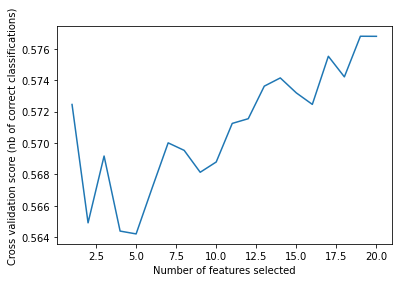

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

cv = StratifiedKFold(2)
rfecv = RFECV(RandomForestClassifier(bootstrap = False), step = 1, cv = cv, scoring = 'precision')
rfecv.fit(X, y)


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [6]:
# Create the RFE object and rank each pixel
from sklearn.feature_selection import RFE

#svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=15, step=1)
rfe.fit(X, y)



pd.DataFrame(rfe.ranking_, X.columns)


,0
DI_Plus,1
ADX,1
CMF,1
DI_Plus_Slope,1
DI_Plus_R,4
Off_SMA,1
Off_LB,1
eps,1
ROE,1
D2C,1


In [7]:
dfrank = pd.DataFrame(rfe.ranking_, X.columns)
dfrank.columns = ['Rank']
keep = dfrank[dfrank.Rank == 1].index

Train Test Split

In [8]:

# Number of trees in random forest
n_estimators = [10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [9]:

rf = RandomForestClassifier(n_jobs = 1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 138.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Best Params

100 estimators, 2 min samples split, 1 min samples leaf, bootstrap = false

Best Score = 90.3

In [14]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [12]:
rf_random.best_score_

0.9034690481213229

2. Drop unimportant columns. Determine and review X2 variable

In [6]:
keep = X.drop(columns = ['DI_Plus_R', 'Sales', 'Percent_Buy', 'E_Season', 'Pos_Coef'])
X2 = dfmodel[keep.columns]
X2.describe().T

,count,mean,std,min,25%,50%,75%,max
DI_Plus,566789.0,23.772818,7.475296,1.101115,18.490152,23.396812,28.567831,75.540116
ADX,566789.0,24.175524,9.798024,4.842246,16.796787,22.203587,29.683063,77.260194
CMF,566789.0,0.036130,0.155913,-0.768655,-0.069970,0.034903,0.141323,0.764770
DI_Plus_Slope,566789.0,0.004983,0.702447,-3.133228,-0.472362,-0.019919,0.455660,4.269575
Off_SMA,566789.0,0.326084,5.071152,-76.959239,-1.761967,0.649648,2.824221,76.286777
Off_LB,566789.0,6.823473,43.658550,-16885.314841,2.302087,4.803678,8.666090,12546.385488
eps,566789.0,4.476524,9.463281,-35.530000,1.630000,3.190000,5.400000,241.290000
ROE,566789.0,0.046136,3.224663,-105.913043,0.071360,0.132320,0.245509,57.800000
D2C,566789.0,21.401924,73.322259,0.000000,1.430524,4.299522,14.358071,1308.970684
epsgrowth,566789.0,63.505620,1202.743595,-19844.380000,-2.620000,1.240000,33.790000,41516.180000


### 3. Initialize model, train test split, fit model and scale

In [7]:
model = RandomForestClassifier(100, n_jobs = -1, random_state = 42, min_samples_leaf = 1, criterion = "gini", min_samples_split = 2, bootstrap = False)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = .25, random_state = 42)

scaler =StandardScaler().fit(X_train)
model.fit(scaler.transform(X_train),y_train)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Run Final Accruacy scores, graph feature importance, review confusion matrix for chosen model

### Run and Test Predicitons on Scaled X_Test

For this project I want to focus on maximizing Precision - minimizing false positive classifications
A false positive would trigger a buy on a stock that will go down causing an actual loss. A false negative would mean I don't buy a stock that is actually going to go up; there would be opportunity cost but not an actual monetary loss.

* Recall = True Positive / (True Positive + False Negative)
* Precision = True Positive / (True Positive + False Positive)
* F1 = (2 x Precision x Recall) / (Precision + Recall)

In [8]:
ypred = model.predict(scaler.transform(X_test))

False Positives in Test: 5887
Chance of FP's  4.15
ROC: 0.924
Accuracy 0.927
Recall 0.945
Precision 0.929
F1 0.936


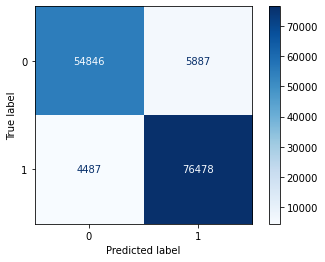

In [9]:
from sklearn.metrics import confusion_matrix
false_positives = confusion_matrix(y_test, ypred)[0][1]
print('False Positives in Test:', false_positives)
print("Chance of FP's ", round(false_positives / len(y_test),4) * 100)
print('ROC:', round(roc_auc_score(y_test, ypred),3))
print('Accuracy', round(accuracy_score(y_test,ypred),3))
print('Recall', round(recall_score(y_test, ypred),3))
print('Precision', round(precision_score(y_test, ypred),3))
print('F1', round(f1_score(y_test, ypred),3))

pd.reset_option('display.float_format')
confmat = plot_confusion_matrix(model, scaler.transform(X_test), y_test, cmap="Blues",values_format='.0f')


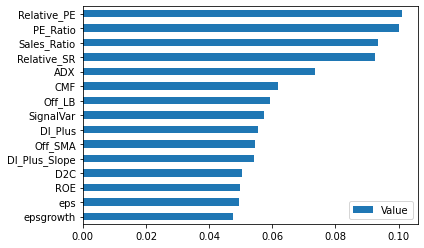

In [11]:
def graph_feature_importances(model, feature_names, autoscale = True, headroom = .05, width = 10, summarized_columns = None):
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
        
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            
            for i in keys_to_remove:
                feature_dict.pop(i)
            
            feature_dict[col_name] = sum_value
            
    results = pd.DataFrame.from_dict(feature_dict, orient = 'index', columns = ['Value'])
    results.sort_values(by = 'Value', inplace = True)
    results.plot(kind = 'barh')
    
    
graph_feature_importances(model, keep)

### Run Cross Val on full set of X2

In [73]:
scores = cross_val_score(model, scaler.transform(X2), y, cv=3, scoring = 'precision')
scores

array([0.58487633, 0.56147397, 0.53581226])

### We'll Try another validation using my Mentor Max Sop's grid_earch_wrapper function

In [13]:
rfc=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample', min_samples_split=2, n_estimators=50, bootstrap = False)

In [23]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, KFold
param_grid = {
    'min_samples_split': [2],
    'n_estimators' : [100],
    'max_depth': [None],
    'max_features': ['auto']
}

scorers = {
#     'sensitivity_score': make_scorer(recall_score(pos_label=1)),
    'precision_score': make_scorer(precision_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [33]:
def grid_search_wrapper(refit_score='recall_score', model=rfc, grid_search=param_grid,
                        X_train = X_train, Y_train = y_train, X_val = X_test, Y_val = y_test):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(model, grid_search, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    # make the predictions
    y_pred = grid_search.predict(X_val)
    print(grid_search.score(X_val, Y_val))

    print('\nBest params for {}'.format(refit_score))
    
    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_true=Y_val, y_pred=y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_pred=y_pred, y_true=Y_val))
    return grid_search

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = .25, random_state = 42)

scaler =StandardScaler().fit(X_train)



In [39]:
grid_search_clf = grid_search_wrapper(refit_score='roc_auc_score', model=rfc, grid_search=param_grid,
                                      X_train=scaler.transform(X_train), Y_train=y_train, X_val=scaler.transform(X_test),
                                      Y_val=y_test)

0.9235896417978543

Best params for roc_auc_score

Confusion matrix of Random Forest optimized for roc_auc_score on the test data:
     pred_neg  pred_pos
neg     54804      5929
pos      4469     76496
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     60733
           1       0.93      0.94      0.94     80965

    accuracy                           0.93    141698
   macro avg       0.93      0.92      0.92    141698
weighted avg       0.93      0.93      0.93    141698



### Max's grid search wrap method returns us back to accuracy and precision scores of over 90%. Overall, accuracy results appear to be mixed. The only way to truly test the performance will be to put this into production and run some live tests on the data. I will continue to monitor the progress over the next 60 days testing on live unseen data without making any stock trading decisions